# Initialisation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv("/home/maylin/Downloads/train_v1.csv")
test = pd.read_csv("/home/maylin/Downloads/test_v1.csv")
validation = pd.read_csv("/home/maylin/Downloads/validation_v1.csv")

X_train = train.drop(["loc_initiator_x", "loc_initiator_y"], axis=1)
y_train = pd.DataFrame(train[["loc_initiator_x", "loc_initiator_y"]])

X_test = test.drop(["loc_initiator_x", "loc_initiator_y"], axis=1)
y_test = pd.DataFrame(test[["loc_initiator_x", "loc_initiator_y"]])

X_valid = validation.drop(["loc_initiator_x", "loc_initiator_y"], axis=1)
y_valid = pd.DataFrame(validation[["loc_initiator_x", "loc_initiator_y"]])

# Entrainement du modele

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tqdm import tqdm
import keras.backend as K
from keras.losses import MeanSquaredError
from keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


cst_nb_neuronne = 256 
cst_drop_out = 0 
nb_couche = 8

neuronal_reseau = []

for nb in tqdm(range(nb_couche)):
  neuronal_reseau += [
    layers.Dense(cst_nb_neuronne, activation='relu'),
    layers.BatchNormalization(), 
    layers.Dropout(cst_drop_out)]

def get_model():
  return keras.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],))]
    + [layers.BatchNormalization()]
    + neuronal_reseau
    + [layers.BatchNormalization()]
    + [layers.Dense(2)])

model = get_model()

model.compile(optimizer=Adam(), loss=["mae"], metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

early_stopping = callbacks.EarlyStopping(min_delta=0.001,
                                         patience=20,
                                         restore_best_weights=True)

lr_rop = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience= 5,
                                              factor = np.sqrt(0.2), verbose = 1,
                                              min_lr = 5e-10)

2023-01-10 15:41:07.047320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-10 15:41:07.287538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-10 15:41:07.287562: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-10 15:41:07.319411: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-10 15:41:08.212291: W tensorflow/stream_executor/platform/de

Epoch 1/250
21/21 [==============================] - 3s 33ms/step - loss: 3.3311 - root_mean_squared_error: 4.4841 - val_loss: 3.4030 - val_root_mean_squared_error: 4.1717 - lr: 0.0010
Epoch 2/250
21/21 [==============================] - 0s 21ms/step - loss: 2.8476 - root_mean_squared_error: 4.0168 - val_loss: 3.4887 - val_root_mean_squared_error: 4.1927 - lr: 0.0010
Epoch 3/250
21/21 [==============================] - 0s 22ms/step - loss: 2.2996 - root_mean_squared_error: 3.3280 - val_loss: 2.0482 - val_root_mean_squared_error: 2.5285 - lr: 0.0010
Epoch 4/250
21/21 [==============================] - 0s 19ms/step - loss: 1.5590 - root_mean_squared_error: 2.4266 - val_loss: 1.8109 - val_root_mean_squared_error: 2.1743 - lr: 0.0010
Epoch 5/250
21/21 [==============================] - 0s 19ms/step - loss: 0.8499 - root_mean_squared_error: 1.3472 - val_loss: 2.8110 - val_root_mean_squared_error: 3.3981 - lr: 0.0010
Epoch 6/250
21/21 [==============================] - 0s 17ms/step - loss: 0

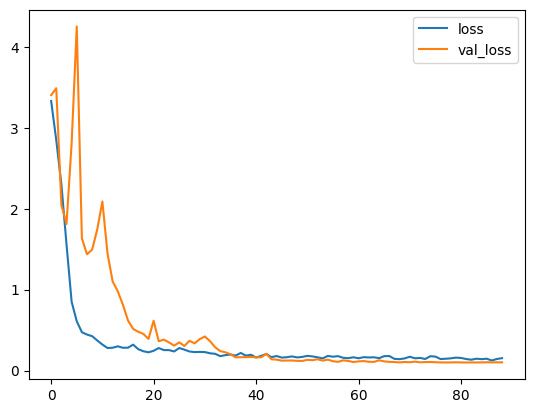

In [5]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size = 128,
    epochs = 250,
    callbacks=[early_stopping, lr_rop]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

In [8]:
from datetime import datetime

curr_time = str(datetime.now())
curr_time = curr_time[:10] + '_H' + curr_time[11:13]+'m'+curr_time[14:16]+'s'+curr_time[17:19]

model.save("modele_loss_"+str(round(history_df['val_loss'].min(),2))+"_"+curr_time)

INFO:tensorflow:Assets written to: modele_loss_0.11_2023-01-10_H15m28s37/assets


# Prediction

In [6]:
deep_pred = model.predict(X_test)

23/23 [==============================] - 0s 3ms/step


In [7]:
df1 = pd.DataFrame(deep_pred, index=X_test.index, columns=['prediction_x', 'prediction_y'])
df2 = y_test
result = pd.concat([df1, df2, X_test], axis=1)

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

true = result[["loc_initiator_y", "loc_initiator_x"]]
pred = result[["prediction_y", "prediction_x"]]

print("mean_absolute_error", mean_absolute_error(true, pred))
print("root_mean_squared_error", mean_squared_error(true, pred, squared=False))

mean_absolute_error 0.3823181016427853
root_mean_squared_error 0.48502756815646125
